# Parametric Court + Dynamic Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

# Court Parameters (editable)

In [2]:
COURT_DEFAULT = {
    # overall court (NBA is 94 x 50)
    "court_length_ft": 94.0,
    "court_width_ft": 50.0,

    # hoop position: distance from baseline to center of rim
    "hoop_from_baseline_ft": 4.0,

    # 3PT geometry (NBA)
    "three_arc_radius_ft": 23.75,
    "corner_three_dist_ft": 22.0,   # horizontal distance from hoop center to corner 3 line

    # paint (NBA lane is 16ft wide; length is 19ft from baseline to FT line)
    "lane_width_ft": 16.0,
    "lane_length_ft": 19.0,

    # free throw circle radius (6ft)
    "ft_circle_radius_ft": 6.0,

    # restricted area radius (4ft)
    "restricted_radius_ft": 4.0,
}

# Geometry helpers (distance, angle, 3PT test)

In [3]:
def inches_to_feet(x_in):
    return x_in / 12.0

def shot_distance_angle(x_in, y_in):
    """
    NBA shotchart coords: basket at (0,0), x left/right, y toward midcourt.
    Inputs are inches; returns (distance_ft, angle_rad, angle_deg).
    """
    x_ft = inches_to_feet(x_in)
    y_ft = inches_to_feet(y_in)
    dist_ft = np.sqrt(x_ft**2 + y_ft**2)
    ang = np.arctan2(y_ft, x_ft)  # radians
    return dist_ft, ang, np.degrees(ang)

def three_break_y_ft(params):
    """
    Where the straight corner line meets the 3pt arc.
    Solve y = sqrt(R^2 - corner^2).
    """
    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    if R <= c:
        return 0.0
    return np.sqrt(R**2 - c**2)

def is_three_pointer(x_in, y_in, params):
    """
    Returns True if (x,y) is behind the 3PT line under current params.
    Uses NBA-style: straight corner lines up to y_break, then circular arc.
    """
    x_ft = inches_to_feet(x_in)
    y_ft = inches_to_feet(y_in)

    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    yb = three_break_y_ft(params)

    # Corner region: y <= yb -> compare |x| to corner dist
    if y_ft <= yb:
        return abs(x_ft) >= c

    # Above the break: compare radial distance to arc radius
    return (x_ft**2 + y_ft**2) >= (R**2)

def add_shot_features(df, params, x_col="LOC_X", y_col="LOC_Y"):
    """
    Adds distance_ft, angle_deg, is_three (based on params) to a shot dataframe.
    Assumes LOC_X/LOC_Y inches from basket.
    """
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()

    x_ft = x / 12.0
    y_ft = y / 12.0

    dist_ft = np.sqrt(x_ft**2 + y_ft**2)
    angle_deg = np.degrees(np.arctan2(y_ft, x_ft))

    # vectorized 3pt
    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    yb = three_break_y_ft(params)

    in_corner_band = y_ft <= yb
    three_corner = (np.abs(x_ft) >= c) & in_corner_band
    three_arc = ((x_ft**2 + y_ft**2) >= R**2) & (~in_corner_band)
    is_three = three_corner | three_arc

    out = df.copy()
    out["distance_ft_new"] = dist_ft
    out["angle_deg_new"] = angle_deg
    out["is_three_new"] = is_three.astype(int)
    return out

# Fixed Court

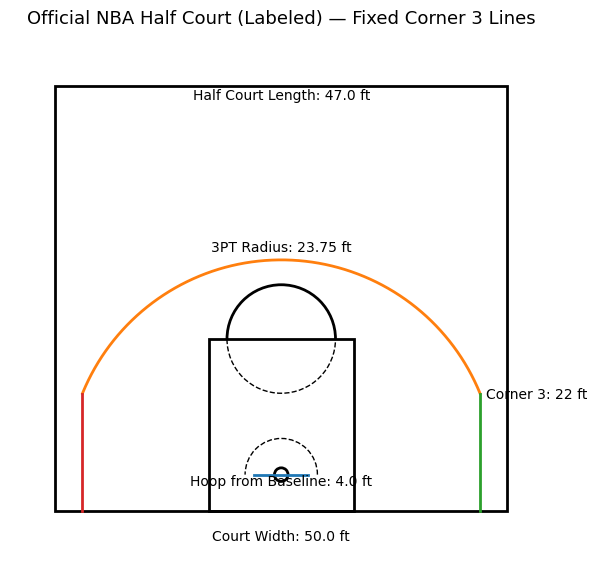

In [10]:
# === Full pasteable cell: Official NBA half-court w/ FIXED corner 3 lines + labeled measurements ===

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

def draw_official_nba_half_court_labeled():
    # -----------------------
    # Official-ish NBA params (feet)
    # -----------------------
    court_width = 50.0
    half_court_length = 47.0          # baseline to half-court line
    hoop_from_baseline = 4.0
    three_arc_radius = 23.75
    corner_three_distance = 22.0      # from hoop centerline (x) to corner 3 line

    # Key areas (approx)
    paint_width = 16.0
    paint_length = 19.0              # baseline to FT line
    backboard_from_baseline = 4.0    # approx location of backboard plane (same as hoop_y here for simple viz)
    backboard_width = 6.0
    rim_radius = 0.75                # 18" diameter => 9" radius => 0.75 ft
    restricted_radius = 4.0

    # -----------------------
    # Setup figure
    # -----------------------
    fig, ax = plt.subplots(figsize=(7, 7))

    # Court boundary (half court)
    ax.add_patch(Rectangle((-court_width/2, 0), court_width, half_court_length,
                           fill=False, linewidth=2))

    # Hoop (rim)
    hoop_x, hoop_y = 0.0, hoop_from_baseline
    ax.add_patch(Circle((hoop_x, hoop_y), rim_radius, fill=False, linewidth=2))

    # Backboard (simple line)
    ax.plot([-backboard_width/2, backboard_width/2], [backboard_from_baseline, backboard_from_baseline], linewidth=2)

    # Paint (lane)
    ax.add_patch(Rectangle((-paint_width/2, 0), paint_width, paint_length,
                           fill=False, linewidth=2))

    # Free throw circle (top half)
    ft_center = (0.0, paint_length)
    ax.add_patch(Arc(ft_center, 12.0, 12.0, angle=0, theta1=0, theta2=180, linewidth=2))
    # Dashed bottom half (NBA style often dashed)
    ax.add_patch(Arc(ft_center, 12.0, 12.0, angle=0, theta1=180, theta2=360, linewidth=1, linestyle="--"))

    # Restricted area arc
    ax.add_patch(Arc((0.0, hoop_y), 2*restricted_radius, 2*restricted_radius,
                     angle=0, theta1=0, theta2=180, linewidth=1, linestyle="--"))

    # -----------------------
    # 3PT arc + FIXED corner lines
    # -----------------------
    R = three_arc_radius

    # Arc endpoints occur where it meets the corner line x = ±corner_x
    corner_x = min(corner_three_distance, (court_width/2) - 0.5)  # keep inside court
    under = R**2 - corner_x**2
    y_corner_end = hoop_y + np.sqrt(under) if under > 0 else hoop_y
    y_corner_end = min(y_corner_end, half_court_length)

    # Draw 3PT arc (only the visible top part that connects corners)
    # Parameterize arc points, then clip to y >= y_corner_end (so it meets corner lines)
    theta = np.linspace(0, np.pi, 600)
    x_arc = hoop_x + R * np.cos(theta)
    y_arc = hoop_y + R * np.sin(theta)

    mask = y_arc >= y_corner_end - 1e-6
    ax.plot(x_arc[mask], y_arc[mask], linewidth=2)

    # Draw corner 3 straight segments at x = ±corner_x from baseline to y_corner_end
    ax.plot([ corner_x,  corner_x], [0, y_corner_end], linewidth=2)
    ax.plot([-corner_x, -corner_x], [0, y_corner_end], linewidth=2)

    # -----------------------
    # Simple measurement labels
    # -----------------------
    ax.text(0, half_court_length - 1.5, f"Half Court Length: {half_court_length:.1f} ft", ha="center")
    ax.text(0, -2.0, f"Court Width: {court_width:.1f} ft", ha="center", va="top")
    ax.text(0, hoop_y + R + 1.0, f"3PT Radius: {R:.2f} ft", ha="center")
    ax.text(corner_x + 0.6, y_corner_end - 0.5, f"Corner 3: {corner_three_distance:.0f} ft", ha="left")
    ax.text(0, hoop_y - 1.2, f"Hoop from Baseline: {hoop_from_baseline:.1f} ft", ha="center")

    # -----------------------
    # Styling
    # -----------------------
    ax.set_aspect("equal")
    ax.set_xlim(-court_width/2 - 5, court_width/2 + 5)
    ax.set_ylim(-5, half_court_length + 6)
    ax.set_title("Official NBA Half Court (Labeled) — Fixed Corner 3 Lines", fontsize=13)
    ax.axis("off")

    plt.show()

draw_official_nba_half_court_labeled()

# Draw a parameterized half-court

In [4]:
def draw_half_court(ax, params, show_labels=False):
    """
    Draw a half court with (0,0) at basket center.
    x in feet left/right; y in feet toward midcourt.
    """
    W = params["court_width_ft"]
    L = params["court_length_ft"]
    hoop_y = 0.0  # basket at y=0 in shot chart coords
    half_court_y = (L / 2.0) - params["hoop_from_baseline_ft"]  # distance from hoop to midcourt

    # boundaries (half court rectangle)
    ax.add_patch(Rectangle((-W/2, -params["hoop_from_baseline_ft"]), W, half_court_y + params["hoop_from_baseline_ft"],
                           fill=False, linewidth=2))

    # hoop
    ax.add_patch(Circle((0, hoop_y), radius=0.75, fill=False, linewidth=2))  # rim radius ~0.75ft (18in)

    # backboard (approx)
    ax.add_patch(Rectangle((-3, -1.0), 6, 0.1, fill=False, linewidth=2))

    # restricted area
    ax.add_patch(Arc((0, 0), 2*params["restricted_radius_ft"], 2*params["restricted_radius_ft"],
                     theta1=0, theta2=180, linewidth=2))

    # paint (lane)
    lane_w = params["lane_width_ft"]
    lane_l = params["lane_length_ft"]
    ax.add_patch(Rectangle((-lane_w/2, -params["hoop_from_baseline_ft"]), lane_w, lane_l + params["hoop_from_baseline_ft"],
                           fill=False, linewidth=2))

    # free throw circle
    ft_y = lane_l  # from hoop coords, FT line is at y=19ft (NBA)
    r = params["ft_circle_radius_ft"]
    ax.add_patch(Arc((0, ft_y), 2*r, 2*r, theta1=0, theta2=180, linewidth=2))
    ax.add_patch(Arc((0, ft_y), 2*r, 2*r, theta1=180, theta2=360, linewidth=2, linestyle="dashed"))

    # 3PT line: corner segments + arc
    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    yb = three_break_y_ft(params)

    # corner lines (from baseline up to yb)
    ax.plot([ c,  c], [-params["hoop_from_baseline_ft"], yb], linewidth=2)
    ax.plot([-c, -c], [-params["hoop_from_baseline_ft"], yb], linewidth=2)

    # arc (from left break to right break)
    # Compute angles where x = +/- c on circle radius R
    if R > c:
        theta = np.degrees(np.arccos(c / R))
        # arc should span from (180-theta) to theta (in matplotlib Arc coords)
        ax.add_patch(Arc((0, 0), 2*R, 2*R, theta1=theta, theta2=180-theta, linewidth=2))

    # formatting
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-W/2 - 2, W/2 + 2)
    ax.set_ylim(-params["hoop_from_baseline_ft"] - 2, half_court_y + 2)
    ax.axis("off")

    if show_labels:
        ax.text(0, half_court_y + 1, f"Half-court Y max ≈ {half_court_y:.1f} ft", ha="center")
        ax.text(0, -params["hoop_from_baseline_ft"] - 1.5, "Baseline", ha="center")

# Static test plot (make sure geometry looks right)

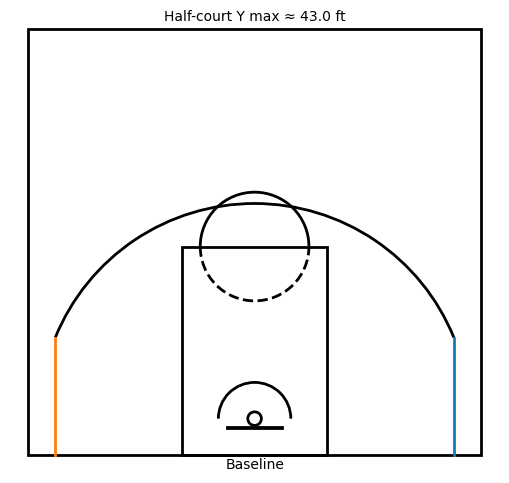

In [5]:
fig, ax = plt.subplots(figsize=(7,6))
draw_half_court(ax, COURT_DEFAULT, show_labels=True)
plt.show()

In [ ]:
from ipywidgets import interact, FloatSlider

def interactive_court(
    three_arc_radius_ft=23.75,
    corner_three_dist_ft=22.0,
    court_width_ft=50.0,
    court_length_ft=94.0,
    hoop_from_baseline_ft=4.0,
):
    params = dict(COURT_DEFAULT)
    params["three_arc_radius_ft"] = three_arc_radius_ft
    params["corner_three_dist_ft"] = corner_three_dist_ft
    params["court_width_ft"] = court_width_ft
    params["court_length_ft"] = court_length_ft
    params["hoop_from_baseline_ft"] = hoop_from_baseline_ft

    fig, ax = plt.subplots(figsize=(7,6))
    draw_half_court(ax, params)
    ax.set_title(
        f"3PT arc={three_arc_radius_ft:.2f}ft | corner={corner_three_dist_ft:.2f}ft | "
        f"court={court_length_ft:.1f}x{court_width_ft:.1f} | hoop baseline={hoop_from_baseline_ft:.1f}ft"
    )
    plt.show()

interact(
    interactive_court,
    three_arc_radius_ft=FloatSlider(min=15.0, max=40.0, step=0.5, value=23.75),
    corner_three_dist_ft=FloatSlider(min=15.0, max=35.0, step=0.5, value=22.0),
    court_width_ft=FloatSlider(min=30.0, max=80.0, step=1.0, value=50.0),
    court_length_ft=FloatSlider(min=60.0, max=140.0, step=2.0, value=94.0),
    hoop_from_baseline_ft=FloatSlider(min=1.0, max=12.0, step=0.5, value=4.0),
);


interactive(children=(FloatSlider(value=23.75, description='three_arc_radius_ft', max=40.0, min=15.0, step=0.5…